In [50]:
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac
import xarray as xr
import cupy as cp
import cupy_xarray  # Adds .cupy to Xarray objects
from pystac_client import Client
import rioxarray as rio
from shapely.geometry import box
import geopandas as gpd
import stackstac
import os
import cupy

In [2]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
catalog

<Client id=microsoft-pc>

In [3]:
lake_rasters = rio.open_rasterio(
    "./surface_CW2019_rasterized_single_grid.tif", chunks="auto"
).squeeze()

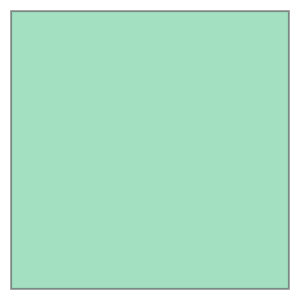

In [4]:
lake_rasters.rio.bounds()
bound_box_3413 = box(*lake_rasters.rio.bounds())
bound_box_3413  

In [5]:
gdf_box = gpd.GeoDataFrame(geometry=[bound_box_3413],crs=3413)
gdf_box_4326 = gdf_box.to_crs(4326)
gdf_box_4326.geometry[0].bounds

(-50.928903512005206, 68.35764741284956, -48.26666489492795, 69.31899293113067)

In [6]:
time_range = '2019-01-01/2019-12-31'

search = catalog.search(collections=["sentinel-1-rtc"], intersects=gdf_box_4326.geometry[0], datetime=time_range)
items = search.get_all_items()
len(items)

/home/laserglaciers/anaconda3/envs/cu_xarray/lib/python3.11/site-packages/pystac_client/item_search.py:849: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


369

In [7]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
df.head(5)

,geometry,datetime,platform,s1:shape,proj:bbox,proj:epsg,proj:shape,end_datetime,constellation,s1:resolution,...,sar:center_frequency,sar:resolution_range,s1:product_timeliness,sar:resolution_azimuth,sar:pixel_spacing_range,sar:observation_direction,sar:pixel_spacing_azimuth,sar:looks_equivalent_number,s1:instrument_configuration_ID,sat:platform_international_designator
0,"POLYGON ((-43.00074 67.11738, -43.20604 66.812...",2019-12-31T09:35:40.725167Z,SENTINEL-1B,"[28945, 22116]","[333220.0, 7410130.0, 622670.0, 7631290.0]",32623,"[22116, 28945]",2019-12-31 09:35:53.224006+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,1,2016-025A
1,"POLYGON ((-46.69624 67.69775, -46.84761 67.483...",2019-12-29T09:51:56.813271Z,SENTINEL-1B,"[28519, 21386]","[430750.0, 7489880.0, 715940.0, 7703740.0]",32622,"[21386, 28519]",2019-12-29 09:52:09.312158+00:00,Sentinel-1,high,...,5.405,20,NRT-3h,22,10,right,10,4.4,1,2016-025A
2,"POLYGON ((-45.21478 69.66482, -45.78214 68.947...",2019-12-29T09:51:29.797754Z,SENTINEL-1B,"[30168, 25979]","[227790.0, 7646700.0, 529470.0, 7906490.0]",32623,"[25979, 30168]",2019-12-29 09:51:44.312877+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,1,2016-025A
3,"POLYGON ((-48.99237 67.32090, -49.17071 67.041...",2019-12-28T10:00:59.852102Z,SENTINEL-1A,"[28461, 22054]","[334920.0, 7436630.0, 619530.0, 7657170.0]",32622,"[22054, 28461]",2019-12-28 10:01:12.351341+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,6,2014-016A
4,"POLYGON ((-47.95501 68.77014, -48.14571 68.508...",2019-12-28T10:00:34.852123Z,SENTINEL-1A,"[28353, 21948]","[372250.0, 7601610.0, 655780.0, 7821090.0]",32622,"[21948, 28353]",2019-12-28 10:00:47.351362+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,6,2014-016A


In [8]:
bounds = gdf_box_4326.geometry[0].bounds
da = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bounds, epsg=3413
)

/home/laserglaciers/anaconda3/envs/cu_xarray/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [9]:
da

<xarray.DataArray 'stackstac-77207c9f224efc67774c91e036b5d467' (time: 369,
                                                                band: 2,
                                                                y: 11562,
                                                                x: 11569)>
dask.array<fetch_raster_window, shape=(369, 2, 11562, 11569), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2019-01-02T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDH_2019...
  * band                                   (band) <U2 'hh' 'hv'
  * x                                      (x) float64 -2.45e+05 ... -1.29e+05
  * y                                      (y) float64 -2.252e+06 ... -2.368e+06
    platform                               (time) <U11 'SENTINEL-1A' ... 'SEN...
    ...                                     ...
    s1:processing_level                    <U1 '1'
    sat:relative_orbit                     (time) int64 25 25 127 ... 127 156
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  (band) <U43 'HH: horizontal transm...
    description                            (band) <U175 'Terrain-corrected ga...
    epsg                                   int64 3413
Attributes:
    spec:           RasterSpec(epsg=3413, bounds=(-244974.672432518, -2367761...
    crs:            epsg:3413
    transform:      | 10.02, 0.00,-244974.67|\n| 0.00,-10.02,-2251864.45|\n| ...
    resolution_xy:  (10.023923746164655, 10.023923743749037)

In [10]:
da = da.as_cupy()

In [11]:
# Check if data is cupy Array
da.cupy.is_cupy

True

In [12]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

In [14]:
da = da.rio.clip([bound_box_3413],da.rio.crs, drop=True,invert=False, all_touched=True) 

In [17]:
da_hh = da.sel(band='hh')
da_hv = da.sel(band='hv')

In [18]:
da

<xarray.DataArray 'stackstac-77207c9f224efc67774c91e036b5d467' (time: 369,
                                                                band: 2,
                                                                y: 9977, x: 9977)>
dask.array<getitem, shape=(369, 2, 9977, 9977), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/40)
  * time                                   (time) datetime64[ns] 2019-01-02T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDH_2019...
  * band                                   (band) <U2 'hh' 'hv'
  * x                                      (x) float64 -2.347e+05 ... -1.347e+05
  * y                                      (y) float64 -2.26e+06 ... -2.36e+06
    platform                               (time) <U11 'SENTINEL-1A' ... 'SEN...
    ...                                     ...
    sat:relative_orbit                     (time) int64 25 25 127 ... 127 156
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  (band) <U43 'HH: horizontal transm...
    description                            (band) <U175 'Terrain-corrected ga...
    epsg                                   int64 3413
    spatial_ref                            int64 0
Attributes:
    spec:           RasterSpec(epsg=3413, bounds=(-244974.672432518, -2367761...
    resolution_xy:  (10.023923746164655, 10.023923743749037)

In [19]:
lake_rasters = lake_rasters.rio.reproject_match(da) #magic

In [62]:
# # Remove any small floating point error in coordinate locations
_, lakes_aligned = xr.align(da, lake_rasters, join="override")
lakes_aligned

<xarray.DataArray (y: 9977, x: 9977)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * x            (x) float64 -2.347e+05 -2.347e+05 ... -1.347e+05 -1.347e+05
  * y            (y) float64 -2.26e+06 -2.26e+06 ... -2.36e+06 -2.36e+06
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        998
    STATISTICS_MEAN:           306.44400977995
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         129.84760361989
    STATISTICS_VALID_PERCENT:  2.454
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0.0

In [63]:
lake_id = np.unique(lakes_aligned.data)
# 0 is used as NULL
lake_id = lake_id[lake_id != 0]
print(f"There are {len(lake_id)} lakes!")

There are 270 lakes!


In [64]:
da_asc = da.where(da['sat:orbit_state'] == 'ascending', drop=True)
da_desc = da.where(da['sat:orbit_state'] == 'descending', drop=True)
da_asc_hv = da_asc.sel(band='hv')
da_asc_hv = da_asc_hv.chunk({"time": 114, "x": 1024/2, "y": 1024/2})
da_asc_hv

<xarray.DataArray 'stackstac-77207c9f224efc67774c91e036b5d467' (time: 114,
                                                                y: 9977, x: 9977)>
dask.array<rechunk-merge, shape=(114, 9977, 9977), dtype=float64, chunksize=(114, 512, 512), chunktype=numpy.ndarray>
Coordinates: (12/40)
  * time                                   (time) datetime64[ns] 2019-01-06T2...
    id                                     (time) <U66 dask.array<chunksize=(114,), meta=np.ndarray>
    band                                   <U2 'hv'
  * x                                      (x) float64 -2.347e+05 ... -1.347e+05
  * y                                      (y) float64 -2.26e+06 ... -2.36e+06
    platform                               (time) <U11 dask.array<chunksize=(114,), meta=np.ndarray>
    ...                                     ...
    sat:relative_orbit                     (time) int64 dask.array<chunksize=(114,), meta=np.ndarray>
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U43 'HV: horizontal transmit, ver...
    description                            <U175 'Terrain-corrected gamma nau...
    epsg                                   int64 3413
    spatial_ref                            int64 0
Attributes:
    spec:           RasterSpec(epsg=3413, bounds=(-244974.672432518, -2367761...
    resolution_xy:  (10.023923746164655, 10.023923743749037)

In [73]:
da_asc_hv = power_to_db(da_asc_hv)
da_asc_hv = da_asc_hv.as_cupy()
da_asc_hv.cupy.is_cupy

True

In [66]:
lakes_aligned = lakes_aligned.as_cupy()
lakes_aligned.cupy.is_cupy
# type(lakes_aligned.data)

True

In [72]:
type(da_asc_hv.data)

dask.array.core.Array

In [74]:
%%time
da_asc_hv_group = da_asc_hv.groupby("time.month").mean().compute()
da_asc_hv_group.cupy.is_cupy

TypeError: Unsupported type <class 'numpy.ndarray'>